# BIA-660 Web Mining Project
## Project Title - Movie Recommendation System
### Objective:
We aim to build a movie recommendation system wherein we will understand the users watch history and recommend movies accordingly. Instead of asking users choice of preference we will extract this information from their watching history.
#### Dataset for our project will be collected from website: https://www.allmovie.com
![alt text](https://upload.wikimedia.org/wikipedia/commons/c/c7/Allmovie_Logo.png "Logo Title Text 1")
This website provide comprehensive movie information including reviews, ratings, biographies etc. We will be looking into more granular data while scraping the data set. Apart from genres, we will be considering keywords, themes, reviews which will be used for multilevel scraping for more accurate prediction.



## Step - 4 EDA - Analysis
* Read the movies10k.csv file.
* Created histograms of keywords and genres.
* Created wordcloud of the same.

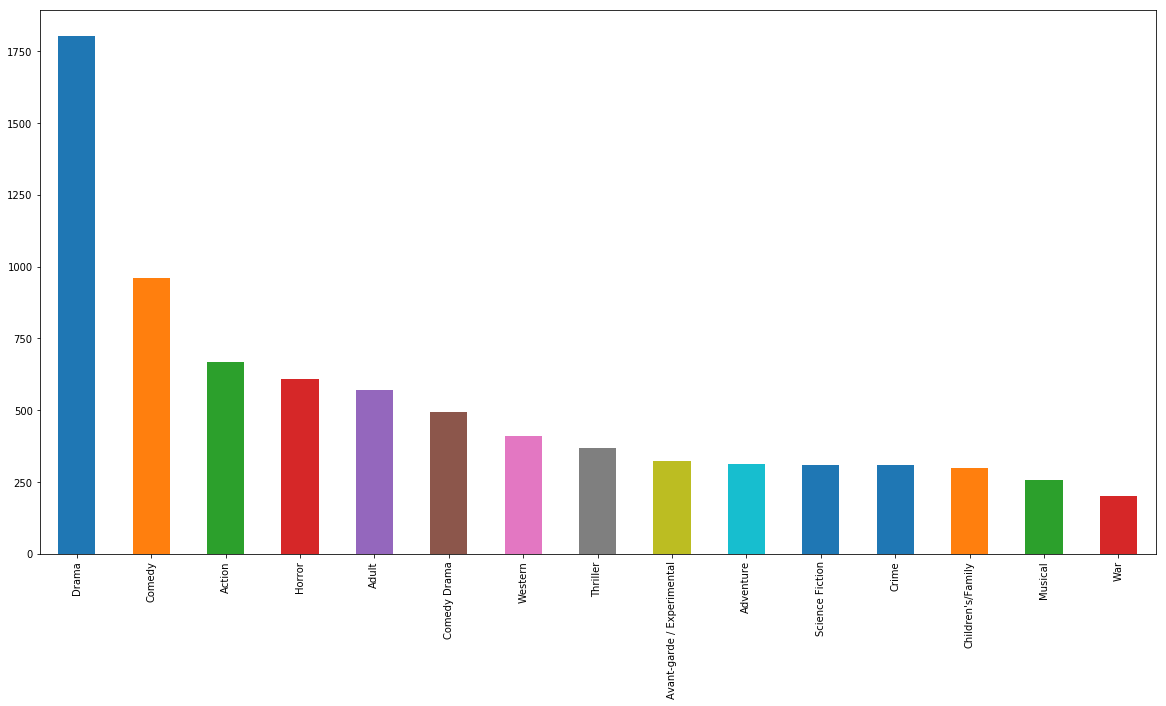

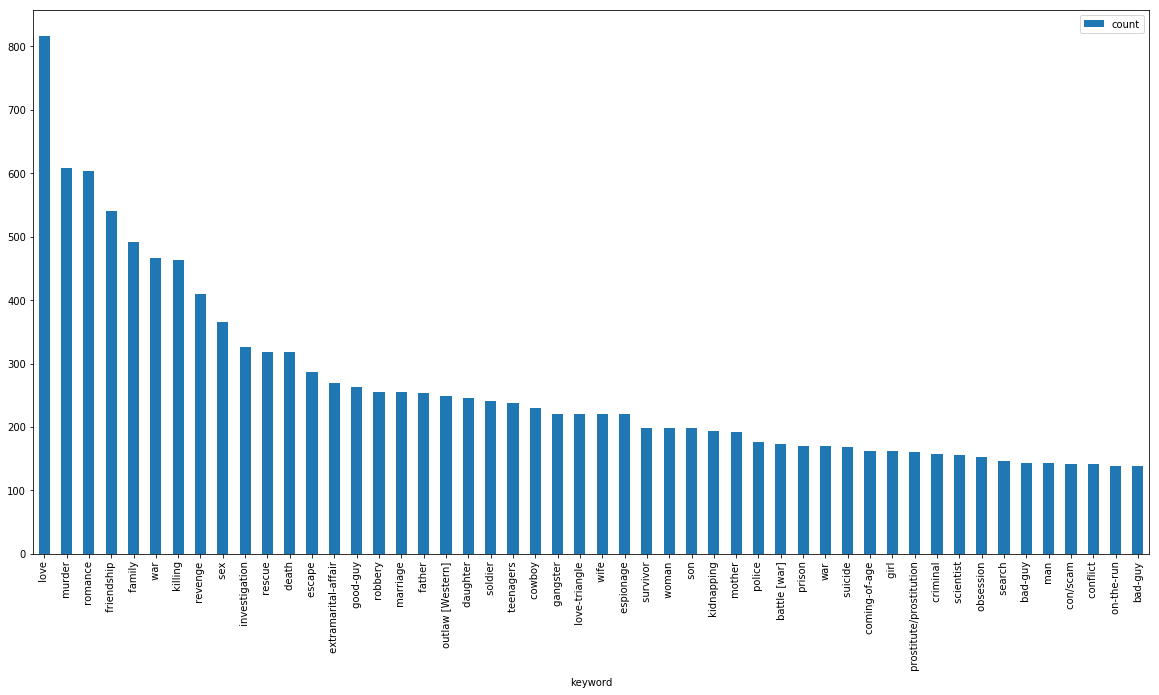

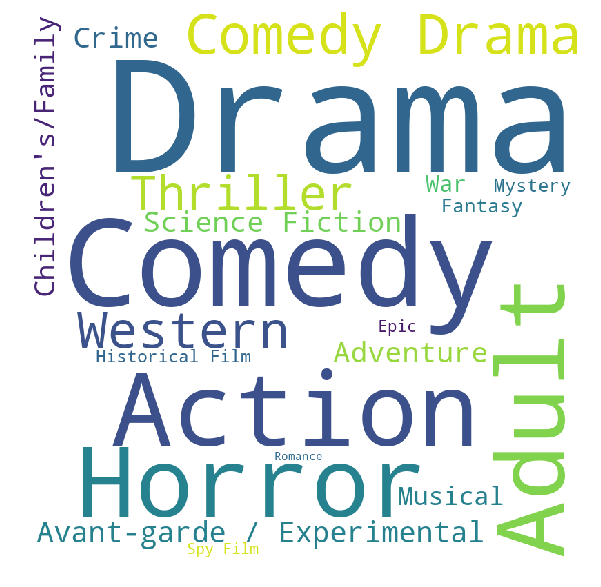

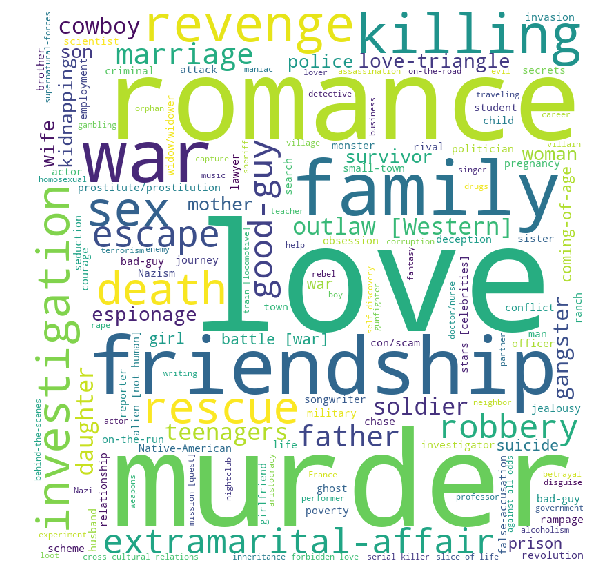

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud,STOPWORDS

def get_keyword_count(keyword_list):
    dict_kwd = {}
    for item in keyword_list:
        list2 = str(item).split(',')
        for t in list2:
            if t in dict_kwd.keys():
                dict_kwd[t]=dict_kwd[t]+1
            else:
                dict_kwd[t]=1
    dict_kwd.pop('nan')
    res=sorted(dict_kwd.items(),key=itemgetter(1),reverse=True)[:50]
    return res,dict_kwd

mvdf = pd.read_csv("movie10k.csv", header =0,encoding="ISO-8859-1")

#create new column for merging keyword,subgenre,theme
mvdf["metadata"]=mvdf["keyword"]+","+mvdf["theme"]+","+mvdf["subgenre"]
    
genre_cnt=(mvdf['genre'].value_counts())

#Histogram of top 15 genres based upon frequency
mvdf['genre'].value_counts()[:15].plot(kind='bar',figsize=(20,10))
    
#Histogram of top 50 keywords based upon frequency
keyword_list = mvdf["keyword"].values.tolist()
key_dict,key_freq = get_keyword_count(keyword_list)
#print(key_dict)
df = pd.DataFrame(key_dict, columns=['keyword', 'count'])
df.plot(kind='bar', x='keyword',figsize=(20,10))

#Wordcloud of top genres based upon frequency
genre_wrdcld = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords_wrdcld, 
                        min_font_size = 10).generate_from_frequencies(genre_cnt) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(genre_wrdcld) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

#Wordcloud of top keywords based upon frequency
key_wrdcld = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords_wrdcld, 
                          min_font_size = 10).generate_from_frequencies(key_freq) 
  
#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(key_wrdcld) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# Step-5 NLP Recommendation Engine
* Defined mapping between wordnet tags and POS tags as a function
* Performed Lemmatization
* Performed tokenization of keywords of each category
* Generated tf-idf matrix for the same.
* Compared all the metadata of the movies like keywords,theme,subgenre and create similarity matrix using cosine similarity.


In [20]:
import nltk
import re
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import word_tokenize

import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from scipy.spatial import distance
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

stop_words = stopwords.words('english')

#adding new stopwords based upon domain knowledge
stop_words.append('nan')

wordnet_lemmatizer = WordNetLemmatizer()
DSTRING='string'
DKEYS='keys'

def tokenize(keywords,dtype):
    keywords=str(keywords)
    token_count={}
    if dtype==DSTRING:
        tokens=word_tokenize(keywords)
    if dtype==DKEYS:
        tokens=[x.strip() for x in keywords.split(",")]
    
    #print(tokens)
    tag_token=nltk.pos_tag(tokens)
    
    #print(tag_token)
    lem_tok=[]
    for (w,tag) in tag_token:
        if w not in stop_words:
            lem_tok.append(wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(tag)))
    #print(lem_tok)
    
    token_count=nltk.FreqDist(lem_tok)
        
    return token_count


def get_top_words(mvdata,n):
    
    topwrds_dict={}
    labels=list(mvdata.keys())
    
    doc_dict={}
    for lb in mvdata.keys():
        doc_dict[lb]=tokenize(mvdata[lb],DKEYS)
    
    #calculate tfidf matrix
    
    #create matrix from dictionary
    dtm=pd.DataFrame.from_dict(doc_dict,orient="index")
    dtm=dtm.fillna(0)
    
    #get normalized term frequency (tf) matrix        
    tf=dtm.values
    doc_len=tf.sum(axis=1)
    tf=np.divide(tf.T, doc_len).T
    
    #get idf
    df=np.where(tf>0,1,0)
    idf=np.log(np.divide(len(mvdata.values()),np.sum(df, axis=0)))+1
    
    #tfidf
    tfidf=normalize(tf*idf)
    #print(tfidf)
    
    smoothed_idf=np.log(np.divide(len(mvdata.values())+1, np.sum(df, axis=0)+1))+1
    #print(smoothed_idf)
    smoothed_tf_idf=normalize(tf*smoothed_idf)
    #print(smoothed_tf_idf)
    
    top=smoothed_tf_idf.argsort()[:,::-1][:,0:n]
    #print(top)
    for idd,row in enumerate(top):
        topwrds_dict[labels[idd]]=[dtm.columns[x] for x in row]
        
    return topwrds_dict

In [21]:
from operator import itemgetter
import matplotlib.pyplot as plt
import pandas as pd

def get_similarity_matrix(mvlst,dtype):
    similarity=None

    mv_dict={}
    for idd,mv_wrds in enumerate(mvlst):
        mv_dict[idd]=tokenize(mv_wrds, dtype)
    
    #print(mv_dict)
    
    #calculate tfidf matrix
    
    #create matrix from dictionary
    dtm=pd.DataFrame.from_dict(mv_dict,orient="index")
    dtm=dtm.fillna(0)
    
    #get normalized term frequency (tf) matrix        
    tf=dtm.values
    doc_len=tf.sum(axis=1)
    tf=np.divide(tf.T, doc_len).T
    
    #get idf
    df=np.where(tf>0,1,0)
    idf=np.log(np.divide(len(mvlst),np.sum(df, axis=0)))+1
    
    #tfidf
    tfidf=normalize(tf*idf)
    print(tfidf)
    
    #find pairwise similarity
    similarity_matrix=1-distance.squareform(distance.pdist(tfidf, 'cosine'))
    #print(similarity_matrix)
    
    return similarity_matrix

def get_similar_movies(similarity_matrix,mvdf,mv_indx,topn):
    best_matching_mv_indx=np.argsort(similarity_matrix)[:, ::-1][mv_indx, 0:topn]
    #if best_matching_mv_indx==mv_indx:
    #    best_matching_mv_nme=np.argsort(similarity_matrix)[:, ::-1][mv_indx, 0:topn]
    similarity=similarity_matrix[mv_indx][best_matching_mv_indx]
    
    return best_matching_mv_indx,similarity


In [23]:
mvdf=None
stopwords_wrdcld=set(STOPWORDS)

#fieldname=["category","movie","title","rating","genre","subgenre","theme","keyword","releasedate","country","review"]
#with open('movie10k.csv') as csv_file:
if __name__ == "__main__":
    mvdf = pd.read_csv("movie10k.csv", header =0,encoding="ISO-8859-1")
    mvkeydict={}
    mvthemedict={}
    for index, row in mvdf.iterrows():
        label=row["category"]
        if label in mvkeydict.keys():
            mvkeydict[label]=mvkeydict[label]+","+str(row["keyword"])
        else:
            mvkeydict[label]=str(row["keyword"])
        if label in mvthemedict.keys():
            mvthemedict[label]=mvthemedict[label]+","+str(row["theme"])
        else:
            mvthemedict[label]=str(row["theme"])
    
    #create new column for merging keyword,subgenre,theme
    mvdf["metadata"]=mvdf["keyword"]+","+mvdf["theme"]+","+mvdf["subgenre"]
    
    #print top n keywords by category
    print("print top keywords by category:")
    print(get_top_words(mvkeydict,3))

    #print top n themes by category
    print("print top themes by category:")
    print(get_top_words(mvthemedict,3)) 
    
    #similaity_matrix by keywords
    sim_mtx_keywords=get_similarity_matrix(mvdf["keyword"].values.tolist(), DKEYS)
    
    #similaity_matrix by theme
    sim_mtx_theme=get_similarity_matrix(mvdf["theme"].values.tolist(), DKEYS)
    
    #similaity_matrix by subgenre
    sim_mtx_subgenre=get_similarity_matrix(mvdf["subgenre"].values.tolist(), DKEYS)
    
    #similaity_matrix by metadata
    sim_mtx_metadata=get_similarity_matrix(mvdf["metadata"].values.tolist(), DKEYS)
    

print top keywords by category:
{'Action': ['Superhero', 'revenge', 'martial-arts'], 'Adult': ['sex', 'bachelorette', 'eroticism'], 'Adventure': ['villain', 'rescue', 'pirate [seafarer]'], 'Avant-garde / Experimental': ['experimental  [arts]', 'filmmaker', 'homosexual'], "Children's/Family": ['friendship', 'animal', 'dog'], 'Comedy': ['love', 'romance', 'friendship'], 'Comedy Drama': ['love', 'friendship', 'romance'], 'Crime': ['gangster', 'organized-crime', 'mob-boss'], 'Drama': ['love', 'family', 'friendship'], 'Epic': ['battle [war]', 'war', 'emperor'], 'Fantasy': ['afterlife', 'love', 'magic'], 'Historical Film': ['war', 'aristocracy', 'king'], 'Horror': ['vampire', 'murder', 'mad-scientist'], 'Musical': ['love', 'performer', 'songwriter'], 'Mystery': ['murder', 'investigation', 'kill'], 'Romance': ['love', 'romance', 'extramarital-affair'], 'Science Fiction': ['alien [not human]', 'future', 'spacecraft'], 'Spy Film': ['espionage', 'agent [representative]', 'spy'], 'Thriller': ['mu

# Step 6 -Testing
* Testing is done by getting similar movies based on keywords,themes,subgenre individually and using metadata column i.e. the combination of these three variables. 

In [24]:
mv_nme="Harry Potter and the Sorcerer's Stone"
mv_indx = mvdf.index[mvdf["movie"]==mv_nme][0]
print(mv_indx)
#(similarity_matrix,mvdf,mv_indx,topn)
topn=5

#get top n movies by keywords
x,y=get_similar_movies(sim_mtx_keywords, mvdf, mv_indx, topn)
print(x,y)
print("top movies by keywords ",mv_nme)
print(mvdf["keyword"].iloc[mv_indx])
print(mvdf["movie"].iloc[x])
print(mvdf["keyword"].iloc[x].values.tolist())
print("****************************************************************")
    
#get top n movies by theme
x,y=get_similar_movies(sim_mtx_theme, mvdf, mv_indx, topn)
print(x,y)
print("top movies by theme ",mv_nme)
print(mvdf["theme"].iloc[mv_indx])
print(mvdf["movie"].iloc[x])
print(mvdf["theme"].iloc[x])
print("****************************************************************")

#get top n movies by subgenre
x,y=get_similar_movies(sim_mtx_subgenre, mvdf, mv_indx, topn)
print(x,y)
print("top movies by subgenre ",mv_nme)
print(mvdf["subgenre"].iloc[mv_indx])
print(mvdf["movie"].iloc[x])
print(mvdf["subgenre"].iloc[x])
print("****************************************************************")

#get top n movies by metadata(keyword,theme,subgenre)
x,y=get_similar_movies(sim_mtx_metadata, mvdf, mv_indx, topn)
print(x,y)
print("top movies by metadata ",mv_nme)
print(mvdf["metadata"].iloc[mv_indx])
print(mvdf["movie"].iloc[x])
print(mvdf["metadata"].iloc[x].values.tolist())
print("****************************************************************")

1394
[1394 2399  565 5743 6791] [1.         0.58469132 0.29720007 0.24459604 0.22626171]
top movies by keywords  Harry Potter and the Sorcerer's Stone
magic, wizard, boarding-school, orphan, owl, centaur, destiny, fantasy-world, hero, mysticism, power, sorcerer, spell [magic], supernatural-powers, witchcraft, chess, dragon, mystery  [whodunit], child-abuse
1394    Harry Potter and the Sorcerer's Stone
2399                            Boogie Nights
565                         Victim of Passion
5743                          Half a Sixpence
6791                              The In-Laws
Name: movie, dtype: object
['magic, wizard, boarding-school, orphan, owl, centaur, destiny, fantasy-world, hero, mysticism, power, sorcerer, spell [magic], supernatural-powers, witchcraft, chess, dragon, mystery  [whodunit], child-abuse', 'pornography, family, sex, director, mother, drugs, disco, ego, film, industry', 'bachelorette, nymphomaniac, sex', 'class-consciousness, girlfriend, high-society, inherita

# Step 7 - Evaluation- NLTK Recommendation Engine 

* Evaluation is done when NLTK package is used.
* Precision and Recall are calculated.

In [25]:
import texttable as tt

#Evaluation using a test file user_data.csv
def get_movie_recom(mv_nme):
    if mv_nme.strip() in mvdf["movie"].values.tolist():
        mv_indx = mvdf.index[mvdf["movie"]==mv_nme][0]
        #print(mv_indx)
        x,y=get_similar_movies(sim_mtx_keywords, mvdf, mv_indx, topn)
        return mvdf["movie"].iloc[x]
    return "Movie Not Found in DB"

def get_movie_recom_eval(mv_nme,topn):
    if mv_nme.strip() in mvdf["movie"].values.tolist():
        mv_indx = mvdf.index[mvdf["movie"]==mv_nme][0]
        #print(mv_indx)
        x,y=get_similar_movies(sim_mtx_keywords, mvdf, mv_indx, topn)
        return mvdf["movie"].iloc[x].values.tolist()
    return "Movie Not Found in DB"

user_data = pd.read_csv("user_data.csv",header=0)[5:15]
tab = tt.Texttable()
headings = ['User','Watch History','Precision','Recall']
tab.header(headings)
#usr_mv=user_data["watchedmovie"].values.tolist()

#Calculating Precision & Recall

for row in user_data.iterrows():
    #print(row[1].values.tolist())
    usrid,usr,preference,favmv,mvlst=row[1].values.tolist()
    cnt=0
    predlst=[]
    reldocno=0.0
    totaldocret=300.0
    noreldoc=7.0
    #print(mvlst.split(','))
    for mv in mvlst.split(','):
        cnt=cnt+1
        if cnt<=3:
            predlst.extend(get_movie_recom_eval(mv,100))
        else:
            if mv.strip() in predlst:
                reldocno=reldocno+1
    #print(usr+": watchedhistory: "+mvlst)
    precision=reldocno/totaldocret
    recall=reldocno/noreldoc
    #print("precision: "+str(precision))
    #print("recall: "+str(recall))
    row=usr,mvlst,precision,recall
    tab.add_row(row)
s = tab.draw()
print(s)

+---------+-----------------------------------------------+-----------+--------+
|  User   |                 Watch History                 | Precision | Recall |
+=========+===============================================+===========+========+
| Nick    | Tootsie,Women on the Verge of a Nervous       | 0.003     | 0.143  |
|         | Breakdown,Roman Holiday,Georgy Girl,It        |           |        |
|         | Happened One Night,A Touch of Class,Born      |           |        |
|         | Yesterday,When Harry Met Sally,Four Weddings  |           |        |
|         | and a Funeral,Working Girl                    |           |        |
+---------+-----------------------------------------------+-----------+--------+
| Sam     | Collateral,The Usual Suspects,The             | 0.007     | 0.286  |
|         | Untouchables,Reservoir Dogs,Sin City,Point    |           |        |
|         | Blank,The Lookout,Gun Crazy,Dirty             |           |        |
|         | Harry,Animal Kin

# Step 8 - Recommendation Engine using Scikit Learn+Testing

* Scikit Learn package is used for recommendation engine.
* Using Scikit Learn API Tf-IDF matrix and cosine similarity is calculated.
* Further testing is done by printing top 5 similar movies using keywords,themes and description.

In [28]:
import numpy as numpy
import pandas as  pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.cluster import KMeansClusterer, cosine_distance
from sklearn.preprocessing import Imputer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
import texttable as tt

#utility function to create a tt table
def zip_func(list1,list2):
    tab = tt.Texttable()
    headings = ['Movie','Rating']
    tab.header(headings)
    for row in zip(list1,list2):
        tab.add_row(row)
        s = tab.draw()
    return s
    
#based upon description
def get_recommendations_title(title):
    idx = indices[title]
    if not idx:
        return "Movie Not Found in DB"
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    return zip_func(titles.iloc[movie_indices].values.tolist(),ratings_data["rating"].iloc[movie_indices].values.tolist())

#based upon keywords
def get_recommendations_keyword(title):
    idx = indices[title]
    if not idx:
        return "Movie Not Found in DB"
    sim_scores = list(enumerate(cosine_sim_keyword[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    return zip_func(titles.iloc[movie_indices].values.tolist(),ratings_data["rating"].iloc[movie_indices].values.tolist())

#based upon Metadata
def get_recommendations_metadata(title):
    idx = indices[title]    
    if not idx:
        return "Movie Not Found in DB"
    sim_scores = list(enumerate(cosine_sim_meta[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    return zip_func(titles.iloc[movie_indices].values.tolist(),ratings_data["rating"].iloc[movie_indices].values.tolist())

#based upon Metadata for evaluation
def get_recommendations_metadata_eval(title,n):
    idx = indices[title]    
    if not idx:
        return "Movie Not Found in DB"
    sim_scores = list(enumerate(cosine_sim_meta[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices].values.tolist()


if __name__== "__main__":
    ratings_data = pd.read_csv("movie10k.csv", encoding='latin-1',header=0)  
    ratings_data.head()    


    tfidf_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
    
    ratings_data['description']=ratings_data['description'].fillna('')
    tfidf_matrix_desc= tfidf_vect.fit_transform(ratings_data['description'])
    cosine_sim = linear_kernel(tfidf_matrix_desc, tfidf_matrix_desc)
    
    ratings_data['keyword']=ratings_data['keyword'].fillna('')
    tfidf_matrix_keyword= tfidf_vect.fit_transform(ratings_data['keyword'])
    cosine_sim_keyword = linear_kernel(tfidf_matrix_keyword, tfidf_matrix_keyword)
    
    ratings_data['theme']=ratings_data['theme'].fillna('')
    tfidf_matrix_theme= tfidf_vect.fit_transform(ratings_data['theme'])
    cosine_sim_theme = linear_kernel(tfidf_matrix_theme, tfidf_matrix_theme)
    
    #create new column for merging keyword,subgenre,theme
    ratings_data["metadata"]=ratings_data["keyword"]+","+ratings_data["theme"]+","+ratings_data["description"]
    ratings_data['metadata']=ratings_data['metadata'].fillna('')
    tfidf_matrix_meta= tfidf_vect.fit_transform(ratings_data['metadata'])
    cosine_sim_meta = linear_kernel(tfidf_matrix_meta, tfidf_matrix_meta)
    
    #cosine_sim = linear_kernel(tfidf_matrix_review, tfidf_matrix_review)
    #print(cosine_sim[0])

    ratings_data = ratings_data.reset_index()
    titles = ratings_data['movie']
    indices = pd.Series(ratings_data.index, index=ratings_data['movie'])
    
    print(get_recommendations_metadata("Iron Man"))
    
    print(get_recommendations_metadata("Harry Potter and the Sorcerer's Stone"))
    

+------------+--------+
|   Movie    | Rating |
+============+========+
| Iron Man 2 | 8      |
+------------+--------+
| Iron Man 3 | 8      |
+------------+--------+
| Avengers:  | 8      |
| Age of     |        |
| Ultron     |        |
+------------+--------+
| Stark      | 6      |
+------------+--------+
| Marvel's   | 9      |
| The        |        |
| Avengers   |        |
+------------+--------+
+-----------------------------------------+--------+
|                  Movie                  | Rating |
+=========================================+========+
| Harry Potter and the Chamber of Secrets | 7      |
+-----------------------------------------+--------+
| Harry Potter and the Prisoner of        | 9      |
| Azkaban                                 |        |
+-----------------------------------------+--------+
| Harry Potter and the Goblet of Fire     | 8      |
+-----------------------------------------+--------+
| Harry Potter and the Order of the       | 8      |
| Phoenix

# Step 9 - Evaluation- Scikit Learn Recommendation Engine

* Evaluation is done when Scikit Learn package is used.
* Precision and Recall are calculated.

In [43]:
user_data = pd.read_csv("user_data.csv",header=0)[5:15]
tab = tt.Texttable()
headings = ['User','Watch History','Precision','Recall']
tab.header(headings)
#print(user_data)
#usr_mv=user_data["watchedmovie"].values.tolist()
for row in user_data.iterrows():
    #print(row[1].values.tolist())
    usrid,usr,preference,favmv,mvlst=row[1].values.tolist()
    cnt=0
    predlst=[]
    reldocno=0.0
    totaldocret=300.0
    noreldoc=7.0
    #print(mvlst.split(','))
    for mv in mvlst.split(','):
        cnt=cnt+1
        if cnt<=3:
            predlst.extend(get_recommendations_metadata_eval(mv,100))
        else:
            if mv.strip() in predlst:
                reldocno=reldocno+1
    #print(usr+": watchedhistory: "+mvlst)
    precision=reldocno/totaldocret
    recall=reldocno/noreldoc
    #print("precision: "+str(precision))
    #print("recall: "+str(recall))
    row=usr,mvlst,precision,recall
    tab.add_row(row)
s = tab.draw()
print(s)

+---------+-----------------------------------------------+-----------+--------+
|  User   |                 Watch History                 | Precision | Recall |
+=========+===============================================+===========+========+
| Nick    | Tootsie,Women on the Verge of a Nervous       | 0         | 0      |
|         | Breakdown,Roman Holiday,Georgy Girl,It        |           |        |
|         | Happened One Night,A Touch of Class,Born      |           |        |
|         | Yesterday,When Harry Met Sally,Four Weddings  |           |        |
|         | and a Funeral,Working Girl                    |           |        |
+---------+-----------------------------------------------+-----------+--------+
| Sam     | Collateral,The Usual Suspects,The             | 0.010     | 0.429  |
|         | Untouchables,Reservoir Dogs,Sin City,Point    |           |        |
|         | Blank,The Lookout,Gun Crazy,Dirty             |           |        |
|         | Harry,Animal Kin

# Step 10 - Chatbot for Demo


In [35]:
#Chatbot for demo purpose
eflag=False
var=None
fflag=False
while not eflag:
    if not fflag:
        print("Movie Recommendation Chatbot")
        var = input("Please enter your name: ")
        print("Welcome " + str(var))
        fflag=True
    fav_mv = input("Please enter one of your favourite movie: ")
    print("Your Top 5 Movie Recommendations are:")
    print(get_recommendations_metadata(fav_mv))
    #print("Your Top 5 Movie Recommendations based on reviews are:")
    #print(get_recommendations_title(fav_mv))
    exit_msg= input("Type 'exit' for stopping the Chatbot or press Enter key to continue")
    if exit_msg.strip()=='exit':
        eflag=True

Movie Recommendation Chatbot
Please enter your name: Niharika
Welcome Niharika
Please enter one of your favourite movie: Skyfall
Your Top 5 Movie Recommendations are:
+---------+--------+
|  Movie  | Rating |
+=========+========+
| Spectre | 9      |
+---------+--------+
| Casino  | 8      |
| Royale  |        |
+---------+--------+
| In Like | 6      |
| Flint   |        |
+---------+--------+
| You     | 8      |
| Only    |        |
| Live    |        |
| Twice   |        |
+---------+--------+
| Shack   | 6      |
+---------+--------+
Type 'exit' for stopping the Chatbot or press Enter key to continueexit


# Step 11- Classification
* We used several classifiers for for prediciting the genre of the movie.
* We used "decscription" of the movie as a parameter to predict the genre.

# Multinomial NB Classifier:
* Description: It is a classification method based on probability bayes theorem with an assumption of independence among predictors. It assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.
* We analysed the performance of Mutinomial NB classifier by calculating the performance metrics like precision, recall and support. Below is the implementation of the algorithm and outputs are noted. 
* O/P : 
1) Confusion matrix graph plotted between y-test and y-train 
2) Bar graph with signifies about the precison vs genre of a particular movie

['In the Mood for Love' 'Tough Guys,Adrenaline Rush' 'Adrenaline Rush' ...
 'Prospectors and Land Rights,Police Corruption'
 'White People Among Indians,Sheriffs and Outlaws'
 'Ranchers,Gender-Bending']
type of dtm: <class 'scipy.sparse.csr.csr_matrix'>
size of tfidf matrix: (5998, 52598)
                            precision    recall  f1-score   support

                    Action       0.00      0.00      0.00        12
                     Adult       0.87      0.76      0.81        79
                 Adventure       0.00      0.00      0.00        26
Avant-garde / Experimental       1.00      0.06      0.11        33
         Children's/Family       1.00      0.04      0.07        27
              Comedy Drama       0.81      0.22      0.35        58
                     Crime       1.00      0.09      0.17        22
                      Epic       0.00      0.00      0.00        19
           Historical Film       1.00      0.05      0.09        22
                    Horror   

c:\users\nihar\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


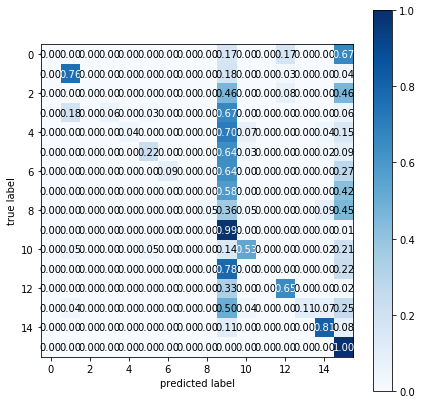

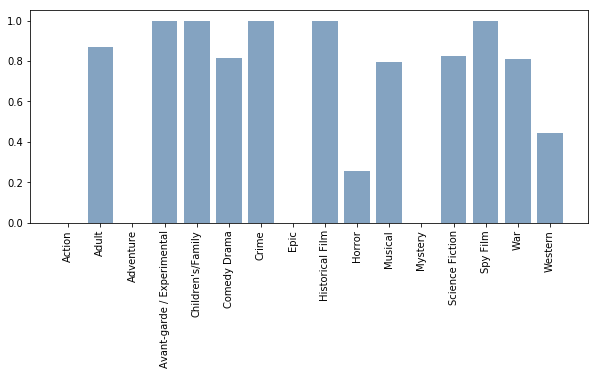

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

data=pd.read_csv("movie10k.csv", header = 0, encoding="ISO-8859-1")
print(data['theme'].unique())
data['theme'].replace('', np.nan, inplace=True)

data['training_text'] = data['title'] + ' ' + data['description'].astype(str)  + ' ' + data['keyword'].astype('U') + data['theme'].astype('U') + data['subgenre'].astype('U')
data = data[data.category != 'Fantasy']
data = data[data.category != 'Drama']
data = data[data.category != 'Romance']
data = data[data.category != 'Comedy']
data = data[data.category != 'Thriller']

# initialize the TfidfVectorizer
tfidf_vect = TfidfVectorizer()

# with stop words removed
tfidf_vect = TfidfVectorizer(stop_words="english")

# generate tfidf matrix
dtm= tfidf_vect.fit_transform(data['training_text'])

print("type of dtm:", type(dtm))
print("size of tfidf matrix:", dtm.shape)

# split dataset into train (70%) and test sets (30%)
X_train, X_test, y_train, y_test = train_test_split(\
                dtm, data["category"], test_size=0.1, random_state=300) # 400

clf = MultinomialNB()
classifier = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# get the list of unique labels
labels=sorted(y_train.unique())

# Support is the number of occurrences of each label
precision, recall, fscore, support= precision_recall_fscore_support(y_test,y_pred,labels=labels)


print(classification_report\
      (y_test,y_pred))

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

cm = confusion_matrix(y_test, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                figsize=(7,7),
                                show_absolute=False,
                                show_normed=True)

plt.show()

bars = tuple(labels)
y_pos = np.arange(len(bars))
plt.figure(figsize=(10,5))

# Create bars
plt.bar(y_pos, precision, color=(0.2, 0.4, 0.6, 0.6))

# Create labels on the x-axis
plt.xticks(y_pos, bars, color='black', rotation=90)
plt.yticks(color='black')
plt.subplots_adjust(bottom=0.4, top=0.99)
plt.show()

# OneVsOne Classifier:

* Definition: In the one-vs-one classification, we train K (K − 1) / 2 binary classifiers for a K-way multiclass problem; each receives the samples of a pair of classes from the original training set, and must learn to distinguish these two classes. Prediction is calculated by the voting scheme applied to all the K (K − 1) / 2 classifiers to an unseen sample and the class that got the highest number of "+1" predictions gets predicted by the combined classifier.

* Below is the implementation code of oneVsone classifier where in we calculated the performance.
* O/P: 
1) Classification Report printed to show the precision, recall, f-1 score and support 
2) Confusion matrix to describe the performance of the classification model 
3) Graph plotted between genre and the precion rate

type of dtm: <class 'scipy.sparse.csr.csr_matrix'>
size of tfidf matrix: (5876, 51801)
                            precision    recall  f1-score   support

                    Action       0.88      0.50      0.64        14
                     Adult       0.88      0.91      0.90        81
                 Adventure       0.60      0.35      0.44        26
Avant-garde / Experimental       0.63      0.66      0.64        29
         Children's/Family       0.78      0.95      0.86        22
              Comedy Drama       0.67      0.89      0.76        62
                     Crime       0.71      0.63      0.67        27
           Historical Film       0.80      0.44      0.57        36
                    Horror       0.83      0.93      0.87        67
                   Musical       0.90      0.86      0.88        51
                   Mystery       0.80      0.47      0.59        17
           Science Fiction       0.86      0.86      0.86        42
                  Spy Film  

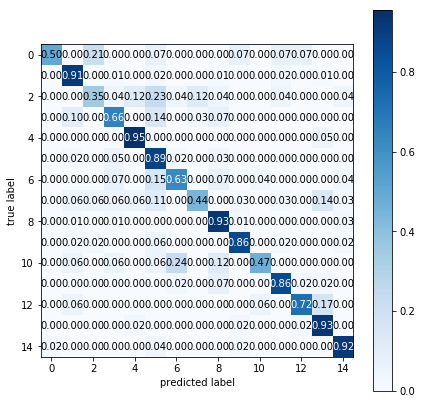

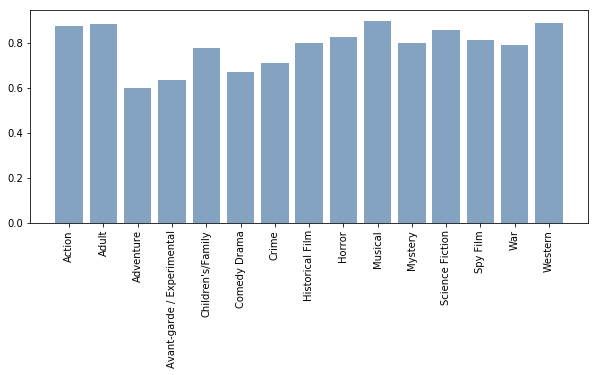

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

data=pd.read_csv("movie10k.csv", header = 0, encoding="ISO-8859-1")
data = data[data.category != 'Epic']
data = data[data.category != 'Fantasy']
data = data[data.category != 'Drama']
data = data[data.category != 'Romance']
data = data[data.category != 'Comedy']
data = data[data.category != 'Thriller']

data['training_data'] = data['description'].astype(str)  + ' ' + data['title'] + ' ' + data['keyword'].astype('U') + data['theme'].astype('U') + data['subgenre'].astype('U')

# initialize the TfidfVectorizer
tfidf_vect = TfidfVectorizer() 

# Remove all the stop words
tfidf_vect = TfidfVectorizer(stop_words="english") 

# Generate the TFIDF Matrix
dtm= tfidf_vect.fit_transform(data['training_data'])

print("type of dtm:", type(dtm))
print("size of tfidf matrix:", dtm.shape)

# Split dataset into train(90%) and test sets(10%)
X_train, X_test, y_train, y_test = train_test_split(dtm, data["category"], test_size=0.1, random_state=300) # 400

# clf = OutputCodeClassifier(LinearSVC())

clf = OneVsOneClassifier(LinearSVC())
classifier = clf.fit(X_train, y_train)

classifier.estimators_
classifier.classes_

# print(classifier.score(X_test,y_test))

# Exercise 4.4 Multi-label classification- Performance report
predicted = classifier.predict(X_test)
# l = classification_report(y_test, predicted)
# precision, recall, fscore, support = classification_report(y_test, predicted)
print(classification_report(y_test, predicted))

labels=sorted(y_train.unique())
precision, recall, fscore, support= precision_recall_fscore_support(y_test, predicted, labels=labels)
print("Precision:")
print(precision)
print("Labels:")
print(labels)


cm = confusion_matrix(y_test, predicted)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                figsize=(7,7),
                                show_absolute=False,
                                show_normed=True)
plt.show()

bars = tuple(labels)
y_pos = np.arange(len(bars))
plt.figure(figsize=(10,5))

# Create bars
plt.bar(y_pos, precision, color=(0.2, 0.4, 0.6, 0.6))

# Create labels on the x-axis
plt.xticks(y_pos, bars, color='black', rotation=90)
plt.yticks(color='black')
plt.subplots_adjust(bottom=0.4, top=0.99)
plt.show()

# Linear SVC:

* Definition: The objective of a Linear SVC (Support Vector Classifier) is to fit to the data you provide, returning a "best fit" hyperplane that divides, or categorizes, your data.

* Below is the implementation code we performed classifion using Linear SVC. 
* O/P: 
1) Printed classification report and noted precision, recall and support 
2) Confusion matrix graph 
3) Graph between precion and genres predicted accuracy.

clf__C :  1.0
tfidf__min_df :  1
tfidf__stop_words :  None
best f1 score: 0.7206214015956195
                            precision    recall  f1-score   support

                    Action       0.88      0.50      0.64        14
                     Adult       0.88      0.93      0.90        81
                 Adventure       0.50      0.31      0.38        26
Avant-garde / Experimental       0.71      0.69      0.70        29
         Children's/Family       0.78      0.95      0.86        22
              Comedy Drama       0.75      0.81      0.78        62
                     Crime       0.75      0.67      0.71        27
           Historical Film       0.70      0.44      0.54        36
                    Horror       0.89      0.93      0.91        67
                   Musical       0.88      0.86      0.87        51
                   Mystery       0.77      0.59      0.67        17
           Science Fiction       0.80      0.88      0.84        42
                  Spy 

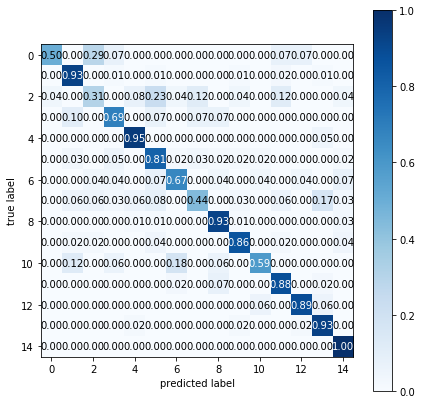

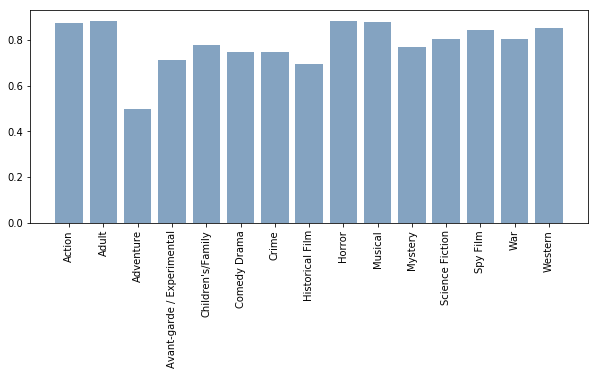

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

data=pd.read_csv("movie10k.csv", header = 0, encoding="ISO-8859-1")
data = data[data.category != 'Epic']
data = data[data.category != 'Fantasy']
data = data[data.category != 'Drama']
data = data[data.category != 'Romance']
data = data[data.category != 'Comedy']
data = data[data.category != 'Thriller']
data['training_text'] = data['title'] + ' ' + data['description'].astype(str)  + ' ' + data['keyword'].astype('U') + data['theme'].astype('U') + data['subgenre'].astype('U')

# split dataset into train (70%) and test sets (30%)
X_train, X_test, y_train, y_test = train_test_split(data["training_text"], data["category"], test_size=0.1, random_state=300)

tfidf_vect = TfidfVectorizer() 
clf = svm.LinearSVC()
metric = "f1_macro"

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', svm.LinearSVC())   #MultinomialNB()    #svm.LinearSVC()
                   ])

parameters = {'tfidf__min_df' : [1,2,5] ,
              'tfidf__stop_words' : [None,"english"] ,
              'clf__C': [0.5,1.0,5.0],
}

gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=6)

gs_clf = gs_clf.fit(X_train, y_train)

for param_name in gs_clf.best_params_:
    print(param_name,": ",gs_clf.best_params_[param_name])

print("best f1 score:", gs_clf.best_score_)

y_pred = gs_clf.predict(X_test)
labels=sorted(y_train.unique())
print(classification_report(y_test, y_pred))
precision, recall, fscore, support= precision_recall_fscore_support(y_test,y_pred,labels=labels)

from sklearn.metrics import confusion_matrix
print("labels: ", labels)
print("precision: ", precision)
print("recall: ", recall)
print("f-score: ", fscore)
print("support: ", support)

cm = confusion_matrix(y_test, y_pred)
print(cm)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                figsize=(7,7),
                                show_absolute=False,
                                show_normed=True)
plt.show()

# Make a fake dataset:
bars = tuple(labels)
y_pos = np.arange(len(bars))
plt.figure(figsize=(10,5))

# Create bars
plt.bar(y_pos, precision, color=(0.2, 0.4, 0.6, 0.6))

# Create names on the x-axis
plt.xticks(y_pos, bars, color='black', rotation=90)
plt.yticks(color='black')
plt.subplots_adjust(bottom=0.4, top=0.99)

# Show graphic
plt.show()

# XGBoost Classifier

* Defnition: XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

* We used XGBoost classifier model to predict the genre of a given movie. We assigned 0,1,2....14 to all the 15 genres which consists of Action, Adult...Western. 
* Below is the implementation code: 
* O/P: 
1) Accuracy of the model 
2) Confusion Matrix 
3) Graph between precision and genre [x-axis: represents the genre value 0,1,2,... maps to Action, Adult... Western]

In [42]:
from sklearn import metrics
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd

data=pd.read_csv("movie10k.csv", header = 0, encoding="ISO-8859-1")
data = data[data.category != 'Epic']
data = data[data.category != 'Fantasy']
data = data[data.category != 'Drama']
data = data[data.category != 'Romance']
data = data[data.category != 'Comedy']
data = data[data.category != 'Thriller']
data['category'].replace('Action',0, inplace=True)
data['category'].replace('Adult',1, inplace=True)
data['category'].replace('Adventure',2, inplace=True)
data['category'].replace('Avant-garde / Experimental',3, inplace=True)
data['category'].replace("Children's/Family",4, inplace=True)
data['category'].replace('Comedy Drama',5, inplace=True)
data['category'].replace('Crime',6, inplace=True)
data['category'].replace('Historical Film',7, inplace=True)
data['category'].replace('Horror',8, inplace=True)
data['category'].replace('Musical',9, inplace=True)
data['category'].replace('Mystery',10, inplace=True)
data['category'].replace('Science Fiction',11, inplace=True)
data['category'].replace('Spy Film',12, inplace=True)
data['category'].replace('War',13, inplace=True)
data['category'].replace('Western',14, inplace=True)


data['training_test'] = data['title'] + ' ' + data['description'].astype(str)  + ' ' + data['keyword'].astype('U') + data['theme'].astype('U') + data['subgenre'].astype('U')

# initialize the TfidfVectorizer 
tfidf_vect = TfidfVectorizer() 

# with stop words removed
tfidf_vect = TfidfVectorizer(stop_words="english") 

# generate tfidf matrix
dtm= tfidf_vect.fit_transform(data['training_test'])

# split dataset into train (70%) and test sets (30%)
X_train, X_test, y_train, y_test = train_test_split(\
                dtm, data["category"], test_size=0.1, random_state=300) # 400 

data.info()

# Using XGboost Classifier
xg_reg = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, preds))



cm = confusion_matrix(y_test, preds)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                figsize=(7,7),
                                show_absolute=False,
                                show_normed=True)
plt.show()

labels=sorted(y_train.unique())
precision, recall, fscore, support= precision_recall_fscore_support(y_test, preds, labels=labels)

print("Precision:")
print(precision)
print("Labels:")
print(labels)

bars = tuple(labels)
y_pos = np.arange(len(bars))
plt.figure(figsize=(10,5))

# Create bars
plt.bar(y_pos, precision, color=(0.2, 0.4, 0.6, 0.6))

# Create labels on the x-axis
plt.xticks(y_pos, bars, color='black', rotation=90)
plt.yticks(color='black')
plt.subplots_adjust(bottom=0.4, top=0.99)
plt.show()


ModuleNotFoundError: No module named 'xgboost'